# Fraud detection

Creation of models to predict instances of fraud using data based on [this dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud).
 
Each row in `fraud_data.csv` corresponds to a credit card transaction. Features include confidential variables `V1` through `V28` as well as `Amount` which is the amount of the transaction. 
 
The target is stored in the `class` column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to an instance of not fraud.

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

df = pd.read_csv("fraud_data.csv")

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Distribution of each class data
counter = Counter(y)
print(counter)

Counter({0: 21337, 1: 356})


In [22]:
# The dataset is unbalanced, we need to oversample the fraud class data and undersample the other class data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# First we oversample the fraud class using the SMOTE method to reach 10% of the non-fraud class data length
over = SMOTE(sampling_strategy=0.1)
# Then we undersample the non-fraud class data to twice the number of the fraud class data
under = RandomUnderSampler(sampling_strategy=0.5)
# We can build a pipeline to chain the transformations
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)

# New distribution
counter = Counter(y)
print(counter)

Counter({0: 4266, 1: 2133})


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
# Now we can build several models and evaluate them
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

clf_svc = SVC().fit(X_train, y_train)
clf_rfdt = RandomForestClassifier().fit(X_train, y_train)

# Logistic regression need a scaling transformation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf_lr = LogisticRegression().fit(X_train_scaled, y_train)

<IPython.core.display.Javascript object>


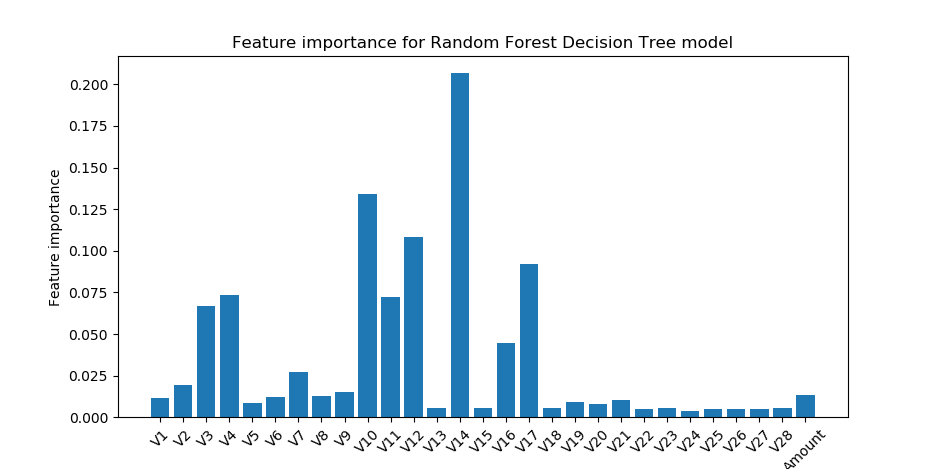

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt
# We can check the features importance of the random forest model to see if some features are more important
features = X.columns
x_bar = np.arange(len(features))

plt.bar(x_bar, clf_rfdt.feature_importances_)
plt.xlabel("Feature name")
plt.ylabel("Feature importance")
plt.title("Feature importance for Random Forest Decision Tree model")
plt.xticks(x_bar, features, rotation=45);

In [16]:
from sklearn.model_selection import cross_val_score
from numpy import mean

# Test recall for the three models
print("Recall svc :", mean(cross_val_score(clf_svc, X, y, scoring='recall')))
print("Recall rfdt :", mean(cross_val_score(clf_rfdt, X, y, scoring='recall')))
print("Recall lr :", mean(cross_val_score(clf_lr, scaler.fit_transform(X), y, scoring='recall')))

Recall svc : 0.7693439324471418
Recall rfdt : 0.9578025530230564
Recall lr : 0.8706083495508571


In [17]:
# The best model is the random forest decision tree, we can now optimise its parameters
from sklearn.model_selection import GridSearchCV

grid_values = {"n_estimators":[10, 50, 100, 200]}
grid_rfdt = GridSearchCV(clf_rfdt, param_grid = grid_values, scoring = 'recall').fit(X_train, y_train)
print("Best param :",grid_rfdt.best_params_)

Best param : {'n_estimators': 200}


In [18]:
# Optimisation of the model and final evaluation
clf_rfdt = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train, y_train)
print("Recall rfdt :", mean(cross_val_score(clf_rfdt, X, y, scoring='recall')))

Recall rfdt : 0.9620224076700641


In [20]:
# Saving the model
import pickle

with open('./fraud_detection.pkl','wb') as model:
    pickle.dump(clf_rfdt, model)